# Computational Methods in Economics

## Lecture 5 - Numerical Optimization

In [188]:
# Author: Alex Schmitt (schmitt@ifo.de)

import datetime
print('Last update: ' + str(datetime.datetime.today()))

Last update: 2017-11-17 11:32:50.203443


### Preliminaries

#### Import Modules

In [2]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

import scipy.optimize

# import sys
from importlib import reload

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'introduction'></a>

## Introduction

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'golden'></a>

## Golden Search

Similar to root finding, for performing numerical optimization we have both derivative-free methods as well as algorithms that either rely on analytical derivatives provided by the user or approximate the derivatives numerically. First, we look at an important method for maximizing a *univariate* function without using derivates, namely *golden search*.

Conceptually, golden search is similar to bisection: we bracket the minimum $x^*$ by the interval $[a, b]$ and then sequentially reduce the length of the interval. One important difference to bisection is that we need to evaluate the function at *two* points inside the bracket, rather than one as in the case of bisection. This is illustrated by the following example:  

In [ ]:
## cp. figure in class
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#

The obvious question is then how to choose the *search points* $c$ and $d$ inside the bracket. **Golden (section) search** prescribes the following rule:
\begin{align}
    c &= a + r (b - a) \\
    d &= b - r (b - a)
\end{align}
where
\begin{equation}
    r = \frac{3 - \sqrt{5}}{2} \approx 0.382...
\end{equation}    

This satisfies two criteria:

- The new interval always has the same length, independent whether the upper or lower bound is replaced:

\begin{equation}
       b - c = d - a = (1 - r)(b - a) 
\end{equation}   

- For every refinement after the first, one of the search points equals the search point from the previous refinement that was not used as a new bound; in other words,

    1. if $f(c) < f(d)$, the new interval is $[a, d]$; for the next refinement, $d' = c$
    2. if $f(c) > f(d)$, the new interval is $[c, b]$; for the next refinement, $c' = d$

This has the advantage that only one function evaluation is performed per iteration; e.g. in the first case, we need to evaluate $f(c')$, but we already have evaluated $f(d') = f(c)$ for the previous refinement. 

In Python, golden section search for minimizing a univariate function is implemented in **scipy.optimize.golden**. Below, we apply it on the function $f(x) = - \exp(-x) \sin(x)$:

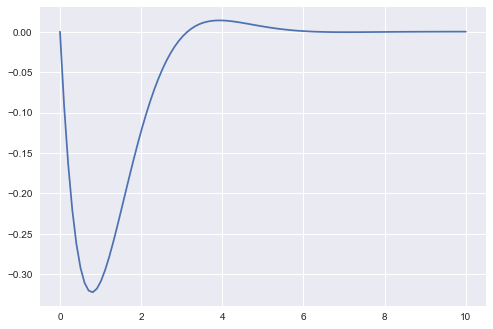

In [5]:
f = lambda x: -np.exp(-x) * np.sin(x)
x = np.linspace(0, 10, 100)
plt.plot(x, f(x))

In [8]:
scipy.optimize.golden(f, brack = (0, 2))

0.7853981651501754

We will not use golden search very often, for the simple reason that we usually optimize over functions with more than one variable. However, golden search is useful in the case of univariate functions with derivatives that are irregular or computationally costly to evaluate.

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'Nelder-Mead'></a>

## Nelder-Mead (Simplex)

Compare http://www.benfrederickson.com/numerical-optimization/ for a visualization.

#### Example: "Banana" function

In [14]:
def banana(x):
    return 100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2

In [16]:
scipy.optimize.minimize(banana, [0, 1], method = 'Nelder-Mead')

 final_simplex: (array([[ 1.00000205,  1.00000565],
       [ 0.99996743,  0.99993257],
       [ 0.99996276,  0.99992823]]), array([  2.42887199e-10,   1.58293615e-09,   2.11970761e-09]))
           fun: 2.4288719914788363e-10
       message: 'Optimization terminated successfully.'
          nfev: 191
           nit: 101
        status: 0
       success: True
             x: array([ 1.00000205,  1.00000565])

Similar to golden search in the univariate case, use the Nelder-Mead algorithm only in cases where a single optimization is performed and evaluating the function and its derivatives is costly. Nelder-Mead is slow and unreliable, in particular for problems with more than two dimensions. In those cases, we are better off with using a variant of the Newton-Raphson method.

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'Newton'></a>

## Newton-Raphson

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'NGM'></a>

## Example: Solving the Neoclassical Growth Model 

As an application of unconstrained optimization over many variables, let's go back the neoclassical growth model. As a reminder, here a concise description of the model: 

- Utility function:

\begin{equation}
    u(c, h) = \frac{c^{1-\nu}}{1-\nu} - B \frac{h^{1+\eta}}{1+\eta}
\end{equation}

with $c$ denoting consumption and $h$ labor supply.

- Production function:

\begin{equation}
    f(k, h) = A k^\alpha h^{1-\alpha}
\end{equation}
with $k$ denoting the capital stock, and $\theta$ a productivity shock.

- Resource Constraint:

\begin{equation}
    k_{t+1} + c_t = f(k_t, h_t) + (1 - \delta) k_t = A k_t^\alpha h_t^{1-\alpha} + (1 - \delta) k_t
\end{equation}

- Planner's Problem:

\begin{equation}
    \max_{\left\{c_t, k_{t+1}, h_t\right\}} \sum^\infty_{t = 0} \beta^t u(c_t, h_t) 
\end{equation}
s.t. the resource constraint.


One obvious issue when trying to solve this model using finite-dimensional optimization is that the version of the model above has an infinite time horizon, and hence infinitely many variables (two per period). There are usually two workarounds: either you solve the model with a finite time horizon $T$ - that is, the economy ends after $T$ periods - but make $T$ large. In this case, we would hope that the economy reaches its steady long before $T$ and hence we can disregard the last few periods. Alternatively, we can include a "continuation value", i.e. impose some conditions on what happens after period $T$. 

In any case, in the simple deterministic NGM with time horizon $T$, we have $2T$ choice variables: in each period, the solution needs to specify a $k_{t+1}$ and a $h_t$.  


#### Parameters

In [141]:
## utility
beta = 0.8      # discount factor
nu = 2       # risk-aversion coefficient for consumption
eta = 1         # elasticity parameter for labor supply
eps = 1e-6      # lower bound of consumption and labor supply
## production
alpha = 0.25
delta = 0.1
## derived
A = (1 - beta * (1 - delta))/(alpha*beta) # normalization parameter for production function => steady state k = 1
B = (1 - alpha) * A * (A - delta)**nu      # parameter for utility function
# B = 0.8
# A = 1.1

k0 = 0.8

#### Compute steady state (from last lecture)

In [167]:
def cd(x, alpha, A):
    """
    Evaluates the Cobb-Douglas function with coefficient alpha and shift parameter A, for two inputs (x)
    """
    return A * x[0]**alpha * x[1]**(1 - alpha)

def cd_diff(x, alpha, A):
    """
    Evaluates the first derivatives (returned as a tuple) of the Cobb-Douglas function with coefficient alpha and shift parameter A, for two inputs (x)
    """
    return (alpha * cd(x, alpha, A) / x[0], (1 - alpha) * cd(x, alpha, A) / x[1])

def steady(x):
    """
    Returns the vector-valued function consisting of the steady-state conditions 
    """
    y = np.zeros(2)
    mp = cd_diff(x, alpha, A)
    
    y[0] = beta * (mp[0] + 1 - delta) - 1
    y[1] = (cd(x, alpha, A) - delta * x[0])**(-nu) * mp[1] - B * x[1]**eta
    
    return y

x0 = np.array([1, 1])
res = scipy.optimize.root(steady, x0,  tol = 1e-8, method = "broyden1")
kss, hss = res.x 

print(res.success)
print(kss, hss)


True
0.704815636211 0.704815636211


#### Define Functions

In [168]:
def cd(x, y):
    """
    Evaluates the Cobb-Douglas function with coefficient alpha and shift parameter A, for two inputs (x)
    """
    return A * x**alpha * y**(1 - alpha)

def u(c, h):
    """
    Utility function
    """
    return c**(1 - nu)/(1 - nu) - B * h**(1 + eta)/(1 + eta)

def objective(x):
    """
    Objective function: lifetime utility
    """
    kp = x[:int(len(x)/2)]
    h = x[int(len(x)/2):]

    k = np.insert(kp[:T-1], 0, k0)
    
    return - ( beta**(np.array(range(T))) @ u( cd(k, h) + (1 - delta) * k - kp, h) 
              + (beta**T/(1 - beta)) *  u( cd(kp[-1], h[-1]) - delta * kp[-1], h[-1]) )

#### Solve model and plot decision variables over time

In [187]:
T = 30

## set bounds
bnds = []
for ind in range(2 * T):
    bnds.append((1e-12, 10000))

## set initial guess    
x0 = np.concatenate([kss * np.ones(T), hss * np.ones(T)])

## solve model
res = scipy.optimize.minimize(objective, x0, method = 'L-BFGS-B', bounds = bnds, tol = 1e-12)
print(res.message)
print(res.success)
x = res.x
kp = x[:int(len(x)/2)]
h =  x[int(len(x)/2):]

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
True


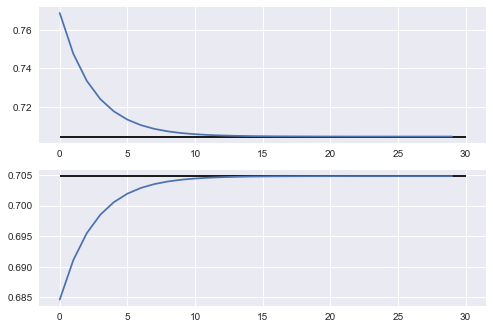

In [186]:
fig, ax = plt.subplots(2,1)
ax[0].plot(kp)
ax[1].plot(h)
ax[0].hlines(kss, 0, T)
ax[1].hlines(hss, 0, T)
